# **Welcome To the Notebook** 


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [2]:
pip install pyspark

     ---------------------------------------- 0.0/317.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.3 MB ? eta -:--:--
     --------------------------------------- 0.0/317.3 MB 59.5 kB/s eta 1:28:50
     --------------------------------------- 0.0/317.3 MB 59.5 kB/s eta 1:28:50
     --------------------------------------- 0.0/317.3 MB 59.5 kB/s eta 1:28:50
     --------------------------------------- 0.0/317.3 MB 59.5 kB/s eta 1:28:50
     --------------------------------------- 0.0/317.3 MB 65.4 kB/s eta 1:20:49
     --------------------------------------- 0.0/317.3 MB 65.4 kB/s eta 1:20:49
     --------------------------------------- 0.0/317.3 MB 65.4 kB/s eta 1:20:49
     -------------------------------------- 0.1/317.3 MB 210.4 kB/s eta 0:2

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    pyspark from https://files.pythonhosted.org/packages/9a/90/cb80c8cf194958ab9a3242851c62fa5aef1a0b42f2d9642f1e2eca098005/pyspark-3.5.3.tar.gz:
        Expected sha256 68b7cc0c0c570a7d8644f49f40d2da8709b01d30c9126cc8cf93b4f84f3d9747
             Got        158e55d0eb2f25da59065008f5e6ff42e3590736d713fb37cc12a9cd847e61df


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing Modules

In [4]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import plotly.express as px 

import pandas as pd

from pyspark.sql.functions import col, when, count, udf

from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [5]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [7]:
data=spark.read.format('csv').option('inferSchema',True).option('header',True).load('Datasets/dataset.csv')
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [8]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension 

In [9]:
print('Number of  columns: ', len(data.columns))
print('Number of Rows: ', data.count())

Number of  columns:  21
Number of Rows:  7043


### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis 
- Univariate Analysis 
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [13]:
numerical_columns = [name for name, typ in data.dtypes if typ in ['double', 'int']]
categorical_columns=[name for name,typ in data.dtypes if typ=='string']
data.select(numerical_columns).show()  # Fixed typo here


+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
|     8|         99.65|       820.5|
|    22|          89.1|      1949.4|
|    10|         29.75|       301.9|
|    28|         104.8|     3046.05|
|    62|         56.15|     3487.95|
|    13|         49.95|      587.45|
|    16|         18.95|       326.8|
|    58|        100.35|      5681.1|
|    49|         103.7|      5036.3|
|    25|         105.5|     2686.05|
|    69|        113.25|     7895.15|
|    52|         20.65|     1022.95|
|    71|         106.7|     7382.25|
|    10|          55.2|      528.35|
|    21|         90.05|      1862.9|
+------+--------------+------------+
only showing top 20 rows



Let's get all the numerical features and store them into a pandas dataframe.

In [15]:
df=data.select(numerical_columns).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns. 

C:\Users\dhima\AppData\Local\Temp\ipykernel_6872\1759971025.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax,bins=20)


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

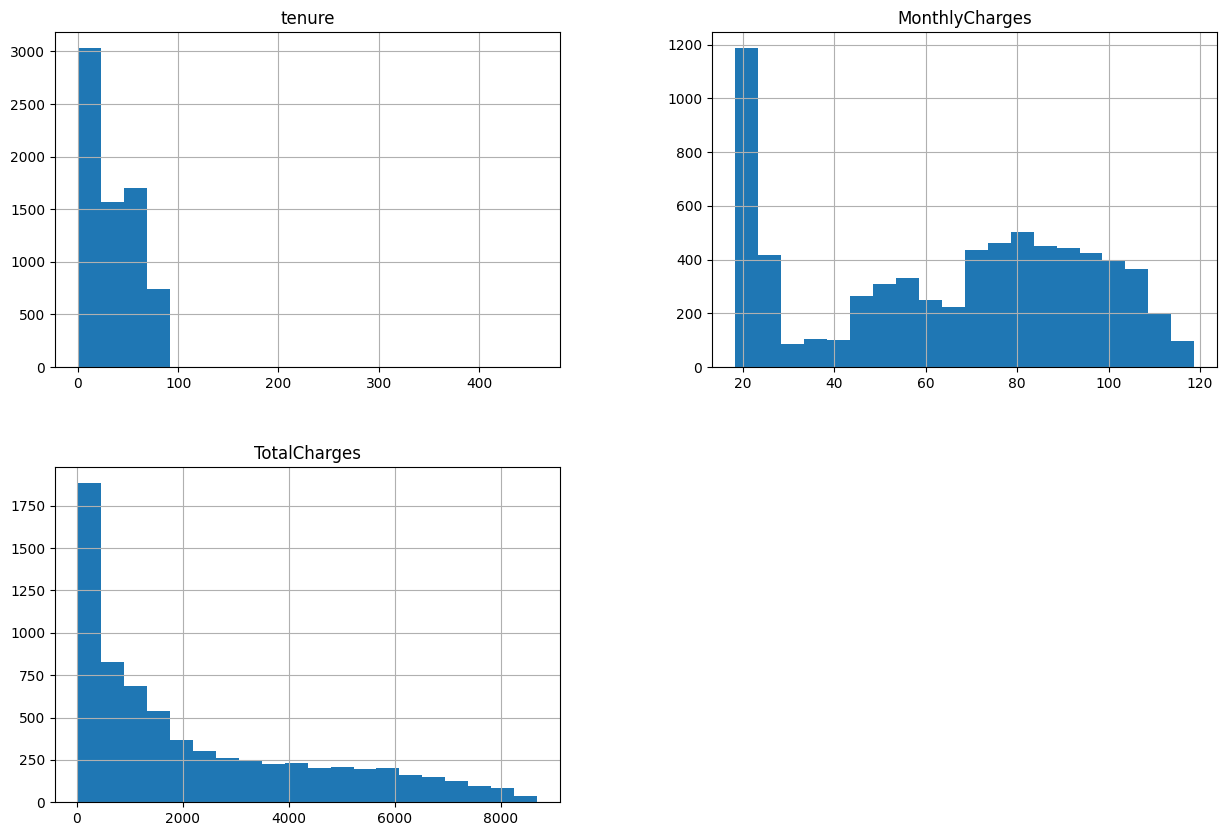

In [16]:
fig=plt.figure(figsize=(15,10))
ax=fig.gca()
df.hist(ax=ax,bins=20)

Let's generate the correlation matrix 

In [17]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [18]:
for column in categorical_columns:
    data.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [19]:
data.select(col('Churn'))

DataFrame[Churn: string]

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [25]:
columns_with_missing_values=['TotalCharges']

Creating our Imputer

In [26]:
imputer =Imputer(inputCols=columns_with_missing_values,outputCols=columns_with_missing_values).setStrategy('mean')

Use Imputer to fill the missing values

In [27]:
imputer=imputer.fit(data)
data=imputer.transform(data)

Let's check the missing value counts again

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100 

Let's drop the outlier row

### **Task 4 - Feature Preparation**
- Numerical Features 
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


**Numerical Scaling** <br>
Let's standardize all of our numerical features. 

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

Let's combine all of our categorifal features in to one feature vector.

Now let's combine categorical and numerical feature vectors.

### **Task 5 - Model Training**
- Train and Test data splitting 
- Creating our model 
- Training our model 
- Make initial predictions using our model

In this task, we are going to start training our model

Now let's create and train our desicion tree

Let's make predictions on our test data

### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set 
- Calculating area under the ROC curve for the `training` set 
- Hyper parameter tuning

Let's get the AUC for our `training` set

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model. 

In [ ]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

Let's visualize our results

### **7 - Model Deployment**
- Giving Recommendations using our model 



We were asked to recommend a solution to reduce the customer churn. 


Let's create a bar chart to visualize the customer churn per contract type

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts. 